In [1]:
from copy import deepcopy

In [2]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1, 1, 1, 1)
plt.rcParams['savefig.dpi'] = 300

In [4]:
!wget -q https://raw.githubusercontent.com/EgorDudyrev/FCApy/main/data/liveinwater.cxt
K = FormalContext.read_cxt('liveinwater.cxt')
!rm liveinwater.cxt

In [5]:
L = ConceptLattice.from_context(K)
len(L)

19

# Concept lattice visualization 

## Default visualization

Let us draw the first draft of a lattice

In [6]:
viz = LineVizNx()

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(11, 14): frozenset({9})}


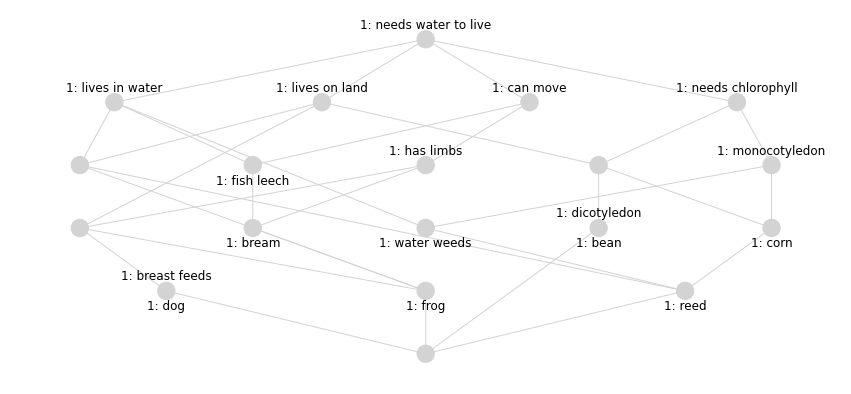

In [7]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(L, ax=ax,)
plt.show()

## Fix the nodes positioning

As the warning says, some edges overlap the nodes. Specifically, edge `(11, 14)` overlaps node `9`.

In order to find the erroneous place we
1. Toogle on `flg_node_indices` parameter to show node indices
2. Highlight edge `(11, 14)` with 'green' color
3. Highlight node `9` with 'pink' color

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(11, 14): frozenset({9})}


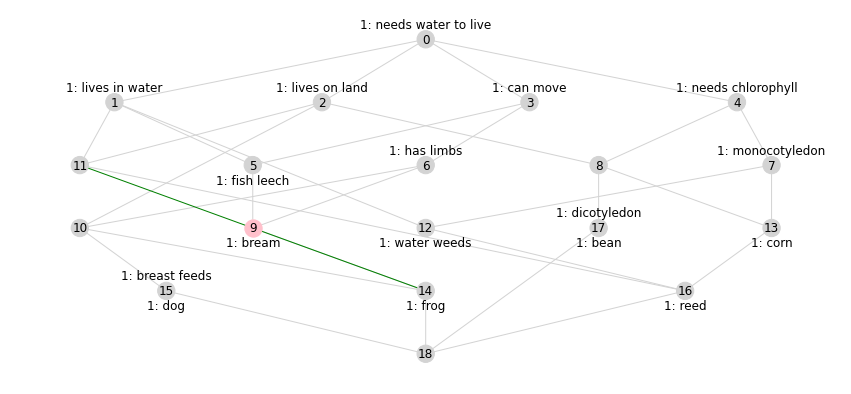

In [8]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_node_indices=True,
    edge_color=['green' if e==(11, 14) else viz.edge_color for e in  L.to_networkx().edges()],
    node_color=['pink' if v == 9 else viz.node_color for v in L.to_networkx().nodes()],
)
plt.show()

Let us move node `14` to the left, just under node `9` to fix the error.

In [9]:
viz.mover.place_node(14, viz.mover.posx[9])

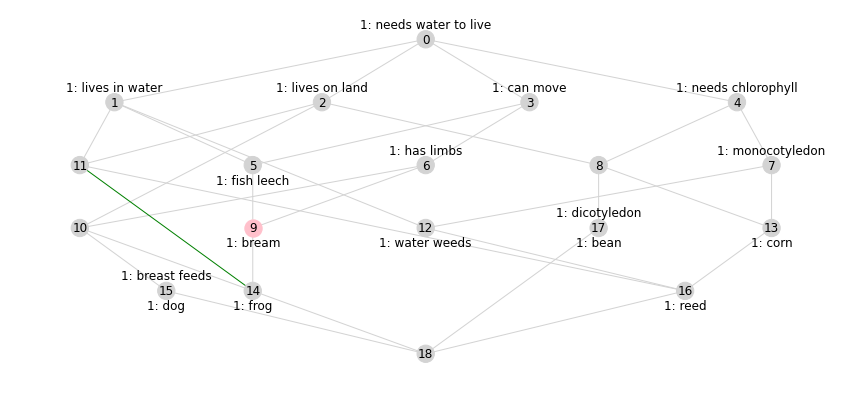

In [10]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_node_indices=True,
    edge_color=['green' if e==(11, 14) else viz.edge_color for e in  L.to_networkx().edges()],
    node_color=['pink' if v == 9 else viz.node_color for v in L.to_networkx().nodes()],
)
plt.show()

Success!

Now no edges overlap the nodes. But the lattice still does not look much pretty. Let us do something with it.

In addition, let us fix the current positioning for the future.

In [11]:
pos_fix = viz.mover.pos

## Manually adjust nodes positioning

In [12]:
viz.mover.pos = pos_fix

First, Also, stop drawing intent and extent counts since they are really small.

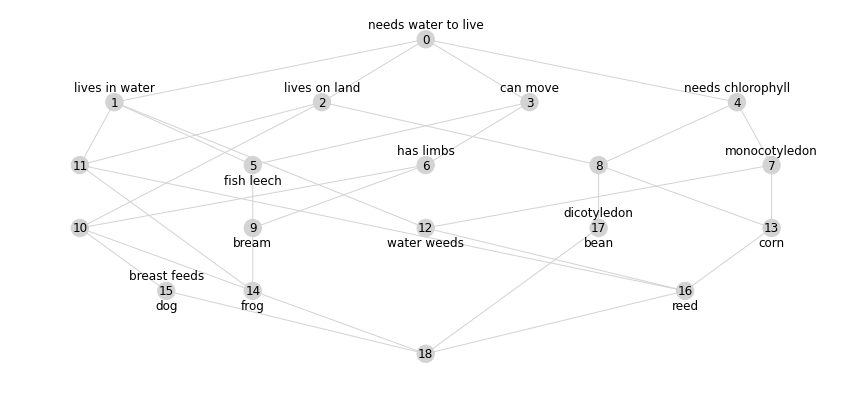

In [13]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_node_indices=True,
    flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False,
)
plt.show()

And now manually move the node positions.

Specifically, move "lives in water" and "lives on land" nodes closer to the center

In [14]:
viz.mover.pos = pos_fix

viz.mover.swap_nodes(1, 3)
viz.mover.swap_nodes(11, 6)
viz.mover.place_node(15, viz.mover.posx[10])

viz.mover.swap_nodes(1, 2)
viz.mover.swap_nodes(9, 10)

dx = (viz.mover.pos[11][0] - viz.mover.pos[14][0])/2
for node_i in [14, 15]:
    viz.mover.jitter_node(node_i, dx)

viz.mover.swap_nodes(8, 7)
viz.mover.swap_nodes(13, 17)
viz.mover.place_node(16, viz.mover.posx[2])

In [15]:
viz.node_label_font_size = 14

The following is somewhat pretty-looking concept lattice for 'Live in water' formal context.

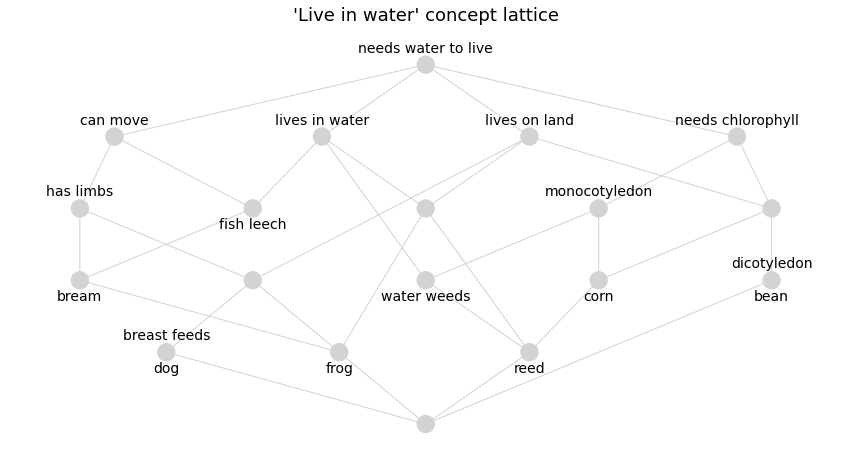

In [16]:
fig, ax = plt.subplots(figsize=(15,8))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_new_intent_count_prefix=False,
    flg_new_extent_count_prefix=False,
    node_alpha=1
)
ax.set_title("'Live in water' concept lattice", size=18)

plt.show()

Formally, this is probably the best Concept Lattice visualization one can get.

But the figure still looks messy. Now, let us go wild and forget about formalities.

# Line and color diagram

## Add colors

Note that "can move" and "needs chlorophyll" are mutually exclusive. They represent animals and plants respectively.

So, the plan is:
1. Remove "lives ..." concepts from the diagram so that "can move" and "needs chlorophyll" form two nonoverlapping upper-semilattices.
2. Represent "lives ..." attributes with colors.
3. Slightly adjust the nodes positions

Removing unnecessary concepts

In [17]:
L_nolives = deepcopy(L)
for c in L:
    if c.intent in {
        ('needs water to live', 'lives in water'),
        ('needs water to live', 'lives on land'),
        ('needs water to live', 'lives in water', 'lives on land')
    }:
        L_nolives.remove(c)

Move "lives ..." attributes from node labels to node colors.

In [18]:
def node_label_func(c_i, L):
    lbl = viz.concept_lattice_label_func(c_i, L, flg_new_extent_count_prefix=False, flg_new_intent_count_prefix=False)
    for s in ['lives in water', 'lives on land', ',']:
        lbl = lbl.replace(s, '')
    return lbl

nodelist = [c_i for c_i, c in enumerate(L_nolives) if c != L_nolives.bottom_concept]
node_color = ['khaki' if 'lives in water' in L_nolives[c_i].intent and 'lives on land' in L_nolives[c_i].intent else
              'forestgreen' if 'lives on land' in L_nolives[c_i].intent else
              'navy' if 'lives in water' in L_nolives[c_i].intent else
              viz.node_color for c_i in nodelist]
node_color_legend = {'khaki': 'lives on land and in water', 'forestgreen': 'lives on land', 'navy': 'lives in water'}

Slightly adjust the nodes positions.

In [19]:
viz.init_mover_per_poset(L_nolives)
viz.mover.place_node(1, (viz.mover.posx[3]+viz.mover.posx[4])/2)
for c_i in [7, 11]:
    viz.mover.place_node(c_i, viz.mover.posx[3])
for c_i in [8, 12]:
    viz.mover.place_node(c_i, viz.mover.posx[4])
for c_i in [9, 10, 14]:
    viz.mover.jitter_node(c_i, viz.mover.posx[0] - viz.mover.posx[8])
for c_i in [2, 10, 13]:
    viz.mover.place_node(c_i, (viz.mover.posx[5]+viz.mover.posx[6])/2)

viz.mover.place_node(14, viz.mover.posx[6])

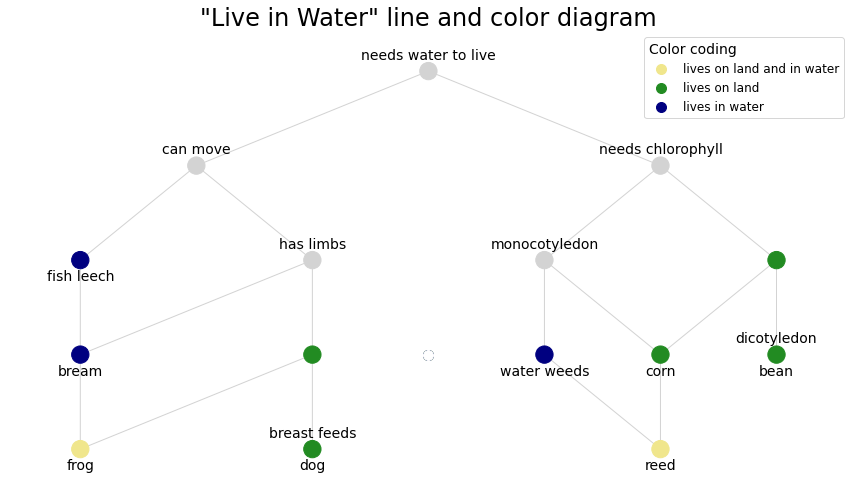

In [20]:
fig, ax = plt.subplots(figsize=(12,7))


viz.draw_concept_lattice(
    L_nolives, ax=ax,
    nodelist=nodelist,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc='upper right')
leg._legend_box.align = "left"

plt.title('"Live in Water" line and color diagram', size=24)
plt.tight_layout()
plt.savefig('imgs/live_in_water_lattice_color.png')
plt.show()

## Remove the nodes that have no new intent or extent

In [21]:
L_nolives2 = deepcopy(L_nolives)
for c_i, c in enumerate(L_nolives):
    if c == L_nolives2.bottom_concept:
        continue
    
    if len(node_label_func(c_i, L_nolives).strip()) == 0:
        L_nolives2.remove(c)

In [22]:
viz.mover.pos = {c_i2: viz.mover.pos[L_nolives.index(c)] for c_i2, c in enumerate(L_nolives2)}

pos_fix = viz.mover.pos

In [23]:
viz.mover.pos = pos_fix

# Move nodes 10 and 12 along the Y coordinates
# (it is supposed to be inconvenient)
viz.mover.pos = {
    c_i: (x, viz.mover.posy[5] if c_i == 12 else viz.mover.posy[6] if c_i == 10 else y)
    for c_i, (x, y) in viz.mover.pos.items()
}

viz.mover.place_node(8, viz.mover.posx[12])

viz.mover.swap_nodes(3, 4)
viz.mover.swap_nodes(6, 10)
viz.mover.place_node(9, viz.mover.posx[6])

In [24]:
nodelist = [c_i for c_i, c in enumerate(L_nolives2) if c != L_nolives2.bottom_concept]
node_color = ['khaki' if 'lives in water' in L_nolives2[c_i].intent and 'lives on land' in L_nolives2[c_i].intent else
              'forestgreen' if 'lives on land' in L_nolives2[c_i].intent else
              'navy' if 'lives in water' in L_nolives2[c_i].intent else
              viz.node_color for c_i in nodelist]
node_color_legend = {'khaki': 'lives on land and in water', 'forestgreen': 'lives on land', 'navy': 'lives in water'}

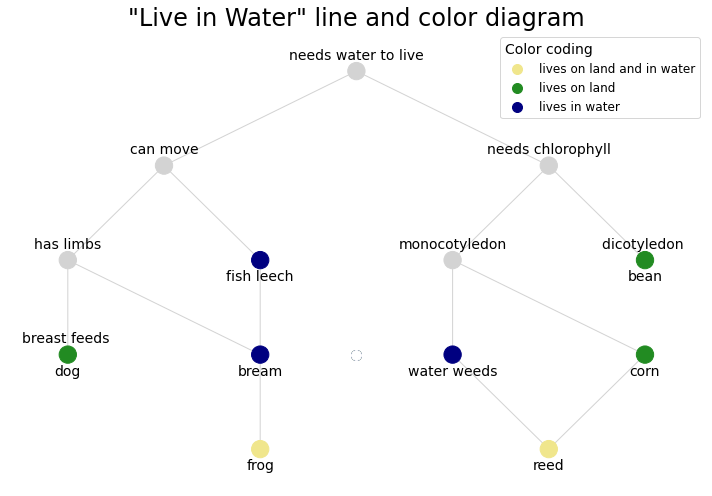

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))

viz.draw_concept_lattice(
    L_nolives2, ax=ax,
    nodelist=nodelist,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc='upper right')
leg._legend_box.align = "left"

plt.title('"Live in Water" line and color diagram', size=24)
plt.tight_layout()
plt.savefig('imgs/live_in_water_lattice_color_short.png')
plt.show()

# In conclusion

In [26]:
import seaborn as sns

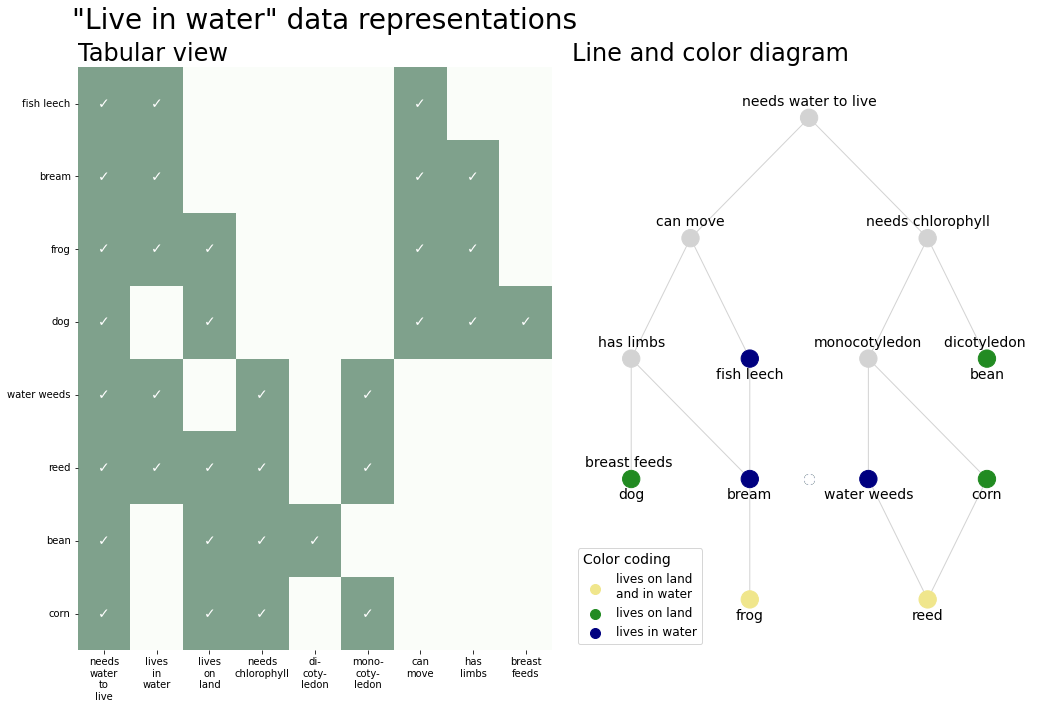

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

ax = axs[0]
sns.heatmap(
    K.to_pandas(), cmap='Greens', alpha=0.5, ax=ax, cbar=False,
    annot=K.to_pandas().replace(True, '✓').replace(False, ''), fmt='', annot_kws={'fontsize': 14},
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels([
    lbl.get_text().replace(' ', '\n') if 'cotyledon' not in lbl.get_text()
    else lbl.get_text().replace('cotyledon', '-\ncoty-\nledon')
    for lbl in ax.get_xticklabels()
], rotation=0)
ax.set_title('Tabular view', size=24, ha='left', x=0.00)



ax = axs[1]

nodelist = [c_i for c_i, c in enumerate(L_nolives2) if c != L_nolives.bottom_concept]
node_color = ['khaki' if 'lives in water' in L_nolives2[c_i].intent and 'lives on land' in L_nolives2[c_i].intent else
              'forestgreen' if 'lives on land' in L_nolives2[c_i].intent else
              'navy' if 'lives in water' in L_nolives2[c_i].intent else
              viz.node_color for c_i in nodelist]
node_color_legend = {'khaki': 'lives on land\nand in water', 'forestgreen': 'lives on land', 'navy': 'lives in water'}

def node_label_func(c_i, L):
    lbl = viz.concept_lattice_label_func(c_i, L, flg_new_extent_count_prefix=False, flg_new_intent_count_prefix=False)
    for s in ['lives in water', 'lives on land', ',']:
        lbl = lbl.replace(s, '')
    return lbl


viz.draw_concept_lattice(
    L_nolives2, ax=ax,
    nodelist=nodelist,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc='lower left')
leg._legend_box.align = "left"


ax.set_title('Line and color diagram', size=24, ha='left', x=0.0)
ax.set_xlim(-0.8, 0.8)

plt.suptitle('"Live in water" data representations', size=28, ha='left', x=0.07)

plt.subplots_adjust(wspace=5, top=0.25)
plt.tight_layout()
plt.savefig('imgs/live_in_water_representation_comparison.png')
plt.show()